## Compare Sage Lot Pond DEM v. RTK

This is a fully Python implementation of the comparisons made in the notebook `Compare_Sage_Lot_Pond_RTK_DEM`

It make a scatterplots of RTK elevations v. the elevations extracted from the 2011 1-m grid provided by Neil Ganju, and the two 0.5-m DEMs I created in Global Mapper from the 2011 and 2014 lidar point clouds, using only the points classified as "Ground".

The RTK v. DEM comparisons are done here. The RTK points are read in from  `Sage Lot Pond 2017_2018 RTK Surveys.txt`, emailed to me by Meagan on April 30, 2018.

The DEMs did not extend far enough north to include all of the RTK locations, so only the ones in the red boxes (north of Northing = 4601525 m) were used.

![RTK points on the 2014 DEM](RTK_points_on_2014_DEM.jpg "RTK points on the 2014 DEM")

csherwood@usgs.gov 1 May 2018

In [1]:
import numpy as np
import rasterio # must be version >1. (using 1.09)
import pandas as pd
import matplotlib.pyplot as plt
import os as os
%matplotlib inline


In [2]:
# bilinear interpolation
def bilint(z,en):
    """
    Bilinear interpolation in unit square, assuming 2D Python array indexing
    
    Input:
        z  - Matrix of values with 
        en - Coordinates (column, row) for interpolated return value
        
    Returns:
        zi - Interpolated value
        
    No checks to ensure en is in the range [0:numcol, 0:numrow]
    
    https://en.wikipedia.org/wiki/Bilinear_interpolation for a unit square
    """
    r = en[1]
    c = en[0]
    ir = np.int(r)
    ic = np.int(c)
    rx = r-ir
    cy = c-ic
    zi = z[ir,ic]*(1.-cy)*(1.-rx)+z[ir+1,ic]*cy*(1.-rx)+z[ir,ic+1]*(1.-cy)*rx+z[ir+1,ic+1]*rx*cy
    return zi

In [3]:
# Independent RTK measurements
# read in the transect points
fn_rtk = 'Sage Lot Pond 2017_2018 RTK Surveys.txt'
df=pd.read_csv(fn_rtk, header = 0, delimiter='\t')
print("Read: ",len(df.index),' lines.')

# remove ones north of 4601525.
df.drop(df[df.northing_m >= 4601525.].index, inplace=True)
df.reset_index(drop=True, inplace=True) # Unfortunately, you have to do this to get the index counting from 0 to len
print("Remaining:",df.shape)
df

Read:  379  lines.
Remaining: (327, 3)


,northing_m,easting_m,altitude_m
0,4601290.462,374432.2382,0.4711
1,4601290.466,374432.2309,0.4721
2,4601293.068,374428.6940,0.4221
3,4601294.136,374428.7351,0.4171
4,4601294.141,374428.7392,0.4171
5,4601294.134,374428.7349,0.4171
6,4601294.216,374427.7118,0.3871
7,4601294.207,374427.7069,0.3881
8,4601294.209,374427.7086,0.3871
9,4601293.167,374427.5834,0.3961




Reading  neil.tif
DEM shape:  (582, 582)

Statistics for interpolated values:
count    327.000000
mean      -0.006239
std        0.046341
min       -0.100354
25%       -0.030002
50%       -0.012185
75%        0.008026
max        0.202358
Name: 2011_1m_DEM_minus_trans (m), dtype: float64


Reading  2011_Lidar_DEM_50cm_ground.tif
DEM shape:  (1207, 1299)

Statistics for interpolated values:
count    327.000000
mean       0.013249
std        0.046370
min       -0.087452
25%       -0.012364
50%        0.006197
75%        0.030090
max        0.213961
Name: 2011_DEM_minus_trans (m), dtype: float64


Reading  2014_Lidar_DEM_50cm_ground.tif
DEM shape:  (1207, 1299)

Statistics for interpolated values:
count    327.000000
mean       0.011148
std        0.047889
min       -0.143272
25%       -0.011221
50%        0.005204
75%        0.026596
max        0.238290
Name: 2014_DEM_minus_trans (m), dtype: float64


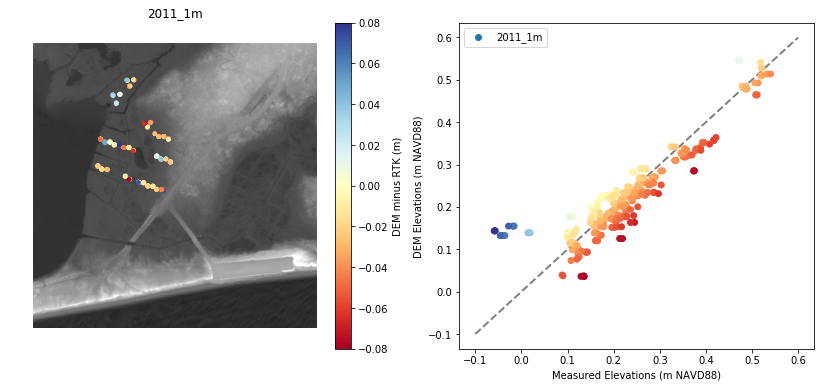

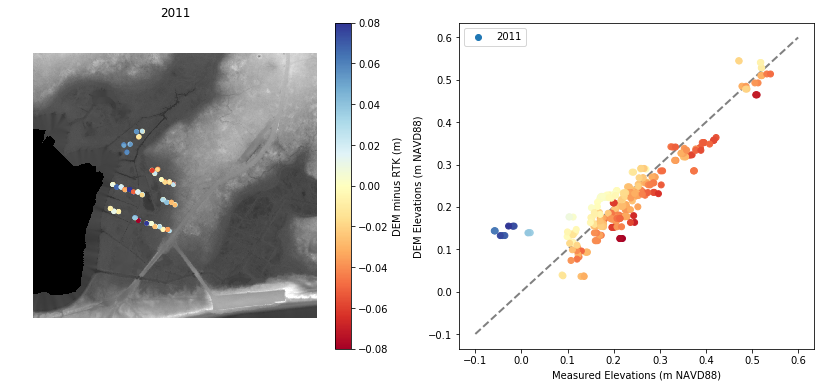

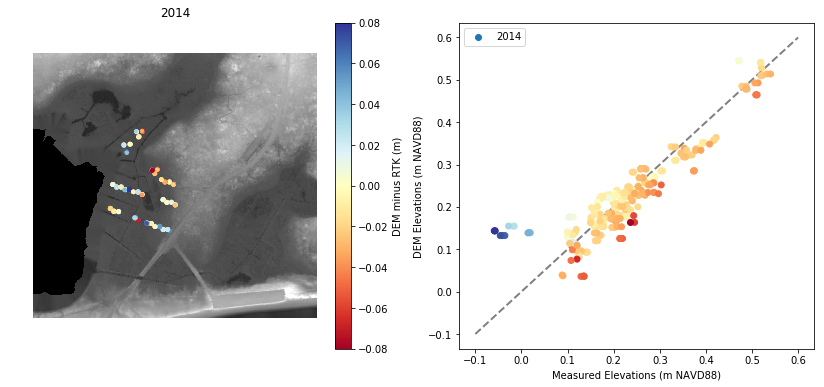

In [6]:
# Loop through the dems and compare

fnames = ("neil.tif",\
          "2011_Lidar_DEM_50cm_ground.tif",\
          "2014_Lidar_DEM_50cm_ground.tif")
flabels = ("2011_1m","2011","2014")

# Read and compare first DEM

nf = len(fnames)
for i in range(nf):
    # read DEM channel 1
    print("\n\nReading ",fnames[i])
    with rasterio.open(fnames[i]) as dem:
        z = dem.read(1)
    print("DEM shape: ",np.shape(z))

    # The transform uses rasterio 
    # print("rasterio gdal version: ",rasterio.gdal_version())
    # coordinate reference system
    # print(dem.crs)
    # data transform
    # print(dem.transform)
    # convert from array index to coordinate units
    # upper left, upper right corner
    ul = dem.transform*(0,0)
    ur = dem.transform*(dem.width,0)
    # lower right , lower left corners
    ll = dem.transform*(0,dem.height)
    lr = dem.transform*(dem.width, dem.height)
    # upper left corner
    # print('upper left: ',ul)
    # lower right corner
    # print('lower right: ',lr)

    # arrays for DEM and differences calcs
    zdem = np.NaN*np.ones(len(df.index))
    zdem_minus_meas = np.NaN*np.ones(len(df.index))

    for index, row in df.iterrows():
        en = ~dem.transform*(row["easting_m"],row["northing_m"])
        # print( index, en )

        # bilinear interpolation in DEM
        try:
            zdem[index]=bilint(z,en)
        except:
            print("interpolation problem")

        # No data values for DEM are -32767
        if(zdem[index]<-32000.):
            zdem[index]=np.NaN           

        zdem_minus_meas[index] = zdem[index]-row["altitude_m"]
        #print( zdem[index], zdi[index], row["elev"], zdem_minus_meas[index]  )

    # add columns to the dataframe
    df[flabels[i]+'_DEM (interp, m)']=pd.Series(zdem,index=df.index)
    df[flabels[i]+'_DEM_minus_trans (m)']=pd.Series(zdem_minus_meas,index=df.index)
    
    print("\nStatistics for interpolated values:")
    print(df[flabels[i]+'_DEM_minus_trans (m)'].describe())
    
    # extract elevations from dataframe
    RTK = df['altitude_m'].values
    
    # make same-sized arrays of coordinates associated with tif elevations
    es = np.linspace(ul[0],lr[0],dem.width);
    ns = np.linspace(ul[1],lr[1],dem.height);
    e, n = np.meshgrid(es, ns)

    # plot two-panel figure
    fig=plt.figure(figsize=(14,6))
    ax=plt.subplot(1,2,1)

    # plot elevation map in gray
    cmap = plt.cm.gray
    plt.pcolormesh(e,n,z,cmap=cmap,vmin=-1,vmax=3)
    plt.axis('equal')
    plt.axis('off')
    plt.title(flabels[i])
    
    # overlay difference values
    dz = df[flabels[i]+'_DEM_minus_trans (m)'].as_matrix()
    x = df['easting_m'].as_matrix()
    y = df['northing_m'].as_matrix()
    plt.scatter(x,y,12,dz,cmap=plt.cm.RdYlBu,vmin=-.08,vmax=.08)
    cb=plt.colorbar()
    cb.set_label('DEM minus RTK (m)')

    # second panel - scatter plot of RTK v. DEM elevations
    ax2 = plt.subplot(1,2,2)
    xx = np.array((-.1,.6))
    yy = np.array((-.1,.6))
    plt.plot(xx,yy, '--k', lw=2,zorder=0,color='gray')
    plt.scatter(RTK,df[flabels[0]+'_DEM (interp, m)'].values,
                c=dz,cmap=plt.cm.RdYlBu,alpha=1,label=flabels[i])
    ax.axis('square')
    ax.axis('equal')
    plt.legend(loc=2)
    plt.xlabel('Measured Elevations (m NAVD88)')
    plt.ylabel('DEM Elevations (m NAVD88)')

    fig_name = flabels[i]+"_DEM_minus_RTK_map+scatter.png"
    fig.savefig(fig_name,dpi=200)

In [ ]:
# extract some columns as arrays and plot
DEM2011 = df[flabels[0]+'_DEM (interp, m)'].values
DEM2014 = df[flabels[1]+'_DEM (interp, m)'].values
RTK = df['altitude_m'].values

fig  = plt.figure(figsize=(7,7))
ax = plt.subplot(1,1,1)
xx = np.array((-.1,.6))
yy = np.array((-.1,.6))
plt.plot(xx,yy, '--k',lw=2,zorder=0,color='gray')
plt.scatter(RTK,DEM2011,alpha=.6,label='2011')
plt.scatter(RTK,DEM2014,alpha=.6,label='2014')
ax.axis('square')
ax.axis('equal')
plt.legend(loc=2)
plt.xlabel('Measured Elevations (m NAVD88)')
plt.ylabel('DEM Elevations (m NAVD88)')
plt.savefig('RTK_DEM_scatterplot_python.png')

In [ ]:
df_fn = "RTK_DEM_comparison_python.txt"
print("\nSaving to ",df_fn)
df.to_csv(df_fn,na_rep='nan',sep=',',float_format='% 12.3f')
df